In [1]:
!pip install transformers
!pip install datasets
# !pip install wandb



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install xformers


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [42]:
import torch.nn as nn
import torch
from transformers import pipeline, set_seed
from transformers import GPT2Tokenizer


class MLP(nn.Module):
    ## multi layer perceptron thats inserted into distilgpt2
    ## function is simple, its 2 linear layers that take the output of the transformer in distilgpt2 and it learns to steer the text into making better prompts
    ## however, we only want to update parameters for the 2 linear layers, not the rest, hence the requires grad being set to false
    ## output of the lm_head in this case is our Q value
    ## lm_head outputs 50k size tensors, and it's argmax is the token that it represents (aka which word to pick out of the 50k vocab size)
    ## according to the paper, this 50k size tensor also represents Q value since it decides which word to pick for our prompt
    ## our 2 linear layers get fed in states aka the previous prompts that we've generated
    ## they learn the appropriate Q value that the lm_head should output for the action of picking a word based on current reward and discounted max future reward (aka the target)
    def __init__(self):
        super().__init__()
        self.lm_pipeline = pipeline('text-generation', model='distilgpt2')
        self.policy = nn.Sequential(
            nn.Linear(768, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 768),
#             nn.ReLU(),
        )
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.0001)
                m.bias.data.fill_(-0.0001)
        self.policy.apply(_init_weights)
        self.lm_pipeline.model.lm_head.requires_grad_(False)
        self.lm_pipeline.model.transformer.requires_grad_(False)
        self.lm_pipeline.model.lm_head = self.lm_pipeline.model.lm_head.to(device)
        self.lm_pipeline.model.transformer = self.lm_pipeline.model.transformer.to(device)
        self.tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', truncation_side = 'left')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.lm_pipeline.model.train()
    def forward(self, x):
        # assert(x.shape[1] == 768)
        # print(x.shape)
        x = self.policy(x)
        return self.lm_pipeline.model.lm_head(x)
    def truncate(self, x):
        arr1 = []
        arr2 = []
        for i in x:
            token = self.tokenizer([i], return_tensors = 'pt')
            inp = token['input_ids'][0,-3:]
            masks = token['attention_mask'][0,-3:]
            arr1.append(inp)
            arr2.append(masks)
        return {'input_ids':torch.cat(arr1).reshape(len(x),-1), 'attention_mask': torch.cat(arr2).reshape(len(x),-1)}
            
    def get_lm_output(self, x):
        with torch.no_grad():
          input = self.truncate(x)
          for key, value in zip(input.keys(), input.values()):
            input[key] = value.to(device)
          return self.lm_pipeline.model.transformer(**input, use_cache=True).last_hidden_state
    def get_prompt(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_greedy(self, x, epsilon):
        # print(x.shape)
        if torch.rand(1) < epsilon:
            return  self.lm_pipeline.tokenizer.decode(torch.randint(0, x.shape[-1], (1,)))
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_softmax_greedy(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode()
    

In [43]:
from transformers import pipeline

import torch
device = 'mps'

class MLM():
  ### Our masked LM model
  ### no learning involved here, just try to get the reward for having it fill it with good vs bad
  def __init__(self):
   self.unmasker = pipeline('fill-mask', model='distilroberta-base')

  def get_masked_word_class(self, input, prompt):
    return self.unmasker(f'{input} {prompt} <mask>', targets = ['good', 'bad'])




In [72]:

import torch
from tqdm import tqdm
# import wandb
### we have states which represents words that we feed into the distilgpt to get better words/prompts
### prompt at time t is a result of picking the action from the mlp that results in the highest reward
### can be written as argmax(reward(MLP(states)), arg = prompt)
### our loss/regression target is essentially reward+discount*max(Q(s_t+1, a'_t+1) for all a')
### this technically isn't the softqlearner, and is generally unstable and produces sparse rewards and takes an extremely long time to train
class QLearner():

    def __init__(self):
        self.mlm = MLM()
        self.mlp = MLP().to(device)
        self.target = MLP().to(device)
#         self.target.load_state_dict(self.mlp.state_dict())
        # torch.manual_seed(95)

        self.last_state = 'this'
        self.prompt_reward = [0]
        self.max_reward = 0
        self.optimizer = torch.optim.AdamW(self.mlp.parameters(), lr=1e-4)
        self.accuracy = []
        self.val_acc = []
        self.loss_ = []
        self.epsilon = .9
    def randomize(self, Q, epsilon): 
#         print("max, min ", Q.max(), Q.min())
        r = torch.rand(1)
#         print('before')
#         print(Q.argmax(-1))
        if r < epsilon:
            index = torch.randint(0, Q.shape[-1], (1,))
            
            m = Q.max().item()
            m = 1 if m == 0 else m
            detached = Q.detach()
#             print('index and max prob',index,m)
            detached[:] = 0
            detached[index] = m
#             print('prob:',r)
#         print('after')
#         print(Q.argmax(-1))
        return Q
    # gets the actions for every state, and their Q values. actions in this case are the prompts
    def get_actions_Q (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.mlp.get_lm_output([last_state]).to(device) 
          Q_ = self.mlp(lm_output)
          Q.append(Q_)
          last_state = self.mlp.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state

    def get_actions_Q_target (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.target.get_lm_output([last_state]).to(device) 
          Q_ = self.target(lm_output)
          Q.append(Q_)
          last_state = self.target.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state


    def get_actions_Q_input_specific (self, batch_input):
        actions = []
#         print(len(batch_input))
        lm_output = self.mlp.get_lm_output(batch_input).to(device) 
        Q_ = self.mlp(lm_output)
    
#         print(Q_.shape)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1]) #(16, 50k)
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        
        Q = [[self.randomize(Q_[i], self.epsilon).reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(4):
          lm_output = self.mlp.get_lm_output([ batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to(device) 
          Q_ = self.mlp(lm_output)
        
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(self.randomize(Q_[j], self.epsilon).reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]
        # print(Q)
        # print(actions)
        Q = [torch.cat(Q__).reshape(1,5,-1) for Q__ in Q]
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    def get_actions_Q_input_specific_target (self, batch_input):
        actions = []

        lm_output = self.target.get_lm_output(batch_input).to(device) 
        Q_ = self.target(lm_output)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        Q = [[Q_[i].reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(4):
          lm_output = self.mlp.get_lm_output([batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to(device) 
          Q_ = self.target(lm_output)
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(Q_[j].reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]

        Q = [torch.cat(Q__).reshape(1,5,-1) for Q__ in Q]
        # for i in Q:
        #   for j in i:
        #     print(j.shape)
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    # to be updated but currently the reward is set to how many correct classifications can this model make
    def get_reward(self, train_x, train_y, prompt):
        reward = 0
        count = 0
        if '�' in prompt or 'Ġ' in prompt:
            return -10000
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
#                 if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
#                     reward = 
#                 else:
#                     incorrect +=1
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward += (word_cls[0]['score']- word_cls[1]['score'])
                else:
                    reward += (word_cls[1]['score']- word_cls[0]['score'])
                count +=1
        return reward/count
    def get_accuracy(self, train_x, train_y, prompt):
        count = 0
        accurate = 0
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward = word_cls[0]['score']- word_cls[1]['score']
                else:
                    reward = word_cls[1]['score']- word_cls[0]['score']
                count +=1
                accurate = accurate + 1 if reward >0 else accurate
        return accurate/count
  
    def loss(self, train_x, train_y):

        actions, Q = self.get_actions_Q_input_specific(train_x)
#         print(Q.shape)
        reward = torch.tensor([self.get_reward(train_x, train_y, ' '.join(action)) for action in actions]).to(device)
        accuracy = torch.tensor([self.get_accuracy(train_x, train_y, ' '.join(action)) for action in actions])
#         reward = high_reward*2-1
#         reward = high_reward
        
        reward = (200**(reward>0))*(100**(reward<=0))*reward
        if reward.std() > 1e-3:
            reward = (reward-reward.mean())/reward.std()
        with torch.no_grad():
          actions_, Q_, = self.get_actions_Q_input_specific_target(train_x)
        return torch.nn.functional.mse_loss(\
            Q, \
            reward.reshape(-1,1,1)+\
            0.99*Q_.detach()), accuracy, [' '.join(action) for action in actions]
    
    def get_accuracy_(self, val_x, val_y, prompts):
#         print(prompts)
        return torch.tensor([self.get_accuracy(val_x, val_y, prompt) for prompt in prompts]).mean()


    def train(self, train_x, train_y, val_x, val_y, epochs):
        
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            loss, reward, prompts = self.loss(train_x, train_y)
            loss.backward()
            self.optimizer.step()
#             train_accuracy = self.get_accuracy_(train_x, train_y, prompts)
#             val_accuracy = self.get_accuracy_(val_x, val_y, prompts)
            self.accuracy.append(reward.mean())
            self.loss_.append(loss.item())
            
            if i %60 == 0:
                self.epsilon = self.epsilon*.9
            
            if i %10==0:
              target_weights = self.target.state_dict()
              for key in target_weights:
                target_weights[key] = self.mlp.state_dict()[key] 
              self.target.load_state_dict(target_weights)
              
              val_accuracy = self.get_accuracy_(val_x, val_y, prompts)
              self.val_acc.append(val_accuracy)
              print(f'loss:{loss.item()}, train_acc: {reward.mean()}, val_acc: {val_accuracy}')
              print(f'prompts: {prompts}')
#               wandb.log({"train_acc": reward.mean(), "val_accuracy": val_accuracy, 'prompts':prompts })
            

In [73]:

ql = QLearner()

In [67]:
import pandas as pd
train_x = list(pd.read_csv('sst2_train')['sentence'])
train_y = list(pd.read_csv('sst2_train')['label'])

val_x = list(pd.read_csv('sst2_val')['sentence'])
val_y = list(pd.read_csv('sst2_val')['label'])

In [101]:
import random

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="DQN RLPrompt LOCAL MPS",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 1e-4,
#     "architecture": "DQN",
#     "dataset": "sst",
#     "epochs": 2999,
#     }
# )
ql.train(train_x, train_y, val_x, val_y, epochs = 2999)

  0%|                                     | 1/2999 [01:06<55:02:42, 66.10s/it]

loss:1.628012776374817, train_acc: 0.625, val_acc: 0.5443750023841858
prompts: [', , observation CTR reci', ', 5000 extr , ,', ', , , precon ,', ', , , , Brennan', ', , , , ,', ', , , Pistol ,', ', , , 223 ,', ', ral , , ,']


  0%|▏                                   | 11/2999 [02:56<19:38:51, 23.67s/it]

loss:2.434563159942627, train_acc: 0.578125, val_acc: 0.5118750333786011
prompts: [', , obligations , ,', ', USA , , doors', ', , , , ideally', ', , , , ,', ', , , , ,', ', , , unwittingly Ar', ', , ammy , Oslo', ', , , , immensely']


  1%|▎                                   | 21/2999 [04:47<19:40:39, 23.79s/it]

loss:1.53048574924469, train_acc: 0.625, val_acc: 0.5306249856948853
prompts: [', , , , ,', ', , achine , ,', ', , , , ,', ', , , expected ,', ', Bird , 2048 ,', ', cares , , ,', ', , Hel , ,', ', unf persecuted , ,']


  1%|▎                                   | 31/2999 [06:38<19:22:17, 23.50s/it]

loss:1.1033293008804321, train_acc: 0.546875, val_acc: 0.5275000333786011
prompts: [', , , , ,', ', , , , ,', ', , journal , ,', ', , kcal , ,', ', arat , , ,', ', , , , ,', ', , , , ,', ', , , gu 1985']


  1%|▍                                   | 41/2999 [08:27<19:07:31, 23.28s/it]

loss:2.9778857231140137, train_acc: 0.5625, val_acc: 0.5099999904632568
prompts: [', gospel , unmarked Flavoring', ', , , , occupies', ', , , , pp', ', , , , Super', ', , , , ,', ', Peace , , ike', ', , ]," , ,', ', father , , ,']


  2%|▌                                   | 51/2999 [10:15<18:47:12, 22.94s/it]

loss:1.1640750169754028, train_acc: 0.59375, val_acc: 0.5299999713897705
prompts: [', , , , ,', ', , , Vice ,', ', , , , ,', ', , , Catal ,', ', , , converge ,', ', ]." , , ,', ', beating , , ,', ', , , , ,']


  2%|▋                                   | 61/2999 [12:02<18:43:54, 22.95s/it]

loss:1.702537178993225, train_acc: 0.59375, val_acc: 0.5525000095367432
prompts: [', triangle , , disappearing', ', , , Silk sp', ', , , , ,', ', , , , ,', ', humorous , , ,', ', , , , Republican', ', urse , Pesh ,', ', , , agog ,']


  2%|▊                                   | 71/2999 [13:50<18:42:00, 22.99s/it]

loss:0.6990708708763123, train_acc: 0.53125, val_acc: 0.5199999809265137
prompts: [', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , ISE urred', ', goddamn , , ,', ', , , , ,', ', , , , ,']


  3%|▉                                   | 81/2999 [15:39<18:40:16, 23.04s/it]

loss:1.073413610458374, train_acc: 0.5, val_acc: 0.5193749666213989
prompts: [', , , , ,', ', , bil , ,', ', , , , ,', ', , , consider ,', ', Rough Cro , ,', ', , , Â£ ,', ', , , , ,', ', , , , ,']


  3%|█                                   | 91/2999 [17:27<18:41:31, 23.14s/it]

loss:1.826930284500122, train_acc: 0.59375, val_acc: 0.5318750143051147
prompts: [', , , , ,', ', , , , ,', ', Cor tags SH ,', ', , , , ,', ', esy , , ,', ', , Cardinals , ,', ', drm , , Zone', ', , , , ,']


  3%|█▏                                 | 101/2999 [19:18<18:59:55, 23.60s/it]

loss:1.1230394840240479, train_acc: 0.578125, val_acc: 0.5325000286102295
prompts: [', Typically ãĤµ , ,', ', , , , ,', ', premie , , ,', ', , , , ,', ', manages , , ,', ', , , illo ,', ', , , , ,', ', , , , ,']


  4%|█▎                                 | 111/2999 [21:08<18:47:11, 23.42s/it]

loss:1.3375422954559326, train_acc: 0.515625, val_acc: 0.515625
prompts: [', , , , ,', ', , , Executive environments', ', // 169 Utilities ,', ', Rex , , ,', ', , , , ,', ', , , , ,', ', , , , wn', ', , , , ,']


  4%|█▍                                 | 121/2999 [22:58<18:43:41, 23.43s/it]

loss:0.9760906100273132, train_acc: 0.59375, val_acc: 0.5249999761581421
prompts: [', duties , , ,', ', , , , ,', ', , scarce , ,', ', ellect , , ,', ', , , , ,', ', , , , Oregon', ', antit , , ,', ', , , , ,']


  4%|█▌                                 | 131/2999 [24:49<18:59:09, 23.83s/it]

loss:0.7965598702430725, train_acc: 0.53125, val_acc: 0.5093749761581421
prompts: [', , , , ,', ', , , , ,', ', , , , ,', ', , , Nathaniel ,', ', , , , ,', ', , 121 , ,', ', bouncing , , ,', ', , , , ,']


  5%|█▋                                 | 141/2999 [26:41<18:47:42, 23.67s/it]

loss:1.2150036096572876, train_acc: 0.609375, val_acc: 0.5393749475479126
prompts: [', , , ilty ,', ', , , , ,', ', suspending , , ,', ', , , , awks', ', , , , ATES', ', Niagara , , ,', ', region , , ,', ', , , , ,']


  5%|█▊                                 | 151/2999 [28:37<19:38:53, 24.84s/it]

loss:1.8532124757766724, train_acc: 0.671875, val_acc: 0.5550000071525574
prompts: [', ETF cryptographic , ,', ', , , Ak ,', ', , , , ,', ', , , , essa', ', maps , lington ,', ', parchment , Ever ,', ', , , , ,', ', , , illac ,']


  5%|█▉                                 | 161/2999 [30:31<19:31:58, 24.78s/it]

loss:0.8395696878433228, train_acc: 0.578125, val_acc: 0.5324999690055847
prompts: [', , , , ,', ', , , , ,', ', , , , ,', ', , IGN , ,', ', , , , 644', ', , , , ,', ', , ortality , ,', ', , , , 525']


  6%|█▉                                 | 171/2999 [32:25<18:57:02, 24.12s/it]

loss:2.7890825271606445, train_acc: 0.578125, val_acc: 0.5268750190734863
prompts: [', , , revisions ,', ', , , , ,', ', , , , ,', ', , , , ,', ', unrem , Tyler ,', ', , , , polic', ', Christie , , arch', ', , , , where']


  6%|██                                 | 181/2999 [34:17<18:28:03, 23.59s/it]

loss:2.875368356704712, train_acc: 0.625, val_acc: 0.5418750047683716
prompts: [', Sergeant , , ,', ', , , , ,', ', , , , brittle', ', , , , ,', ', Extra OFFIC , ,', ', , , , word', ', , , Ble ,', ', , wh breaker ,']


  6%|██▏                                | 191/2999 [36:07<18:14:26, 23.39s/it]

loss:1.973981499671936, train_acc: 0.59375, val_acc: 0.5206249952316284
prompts: [', , , , ,', ', ected barbecue gly oma', ', , 333 , ,', ', , , sky $(', ', , , , ,', ', , Match , ,', ', , , , ,', ', , , unwilling ,']


  7%|██▎                                | 201/2999 [37:55<17:57:01, 23.10s/it]

loss:0.6692540645599365, train_acc: 0.515625, val_acc: 0.5118749737739563
prompts: [', , , , ,', ', , , , ,', ', , , , ,', ', , Knight , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  7%|██▍                                | 211/2999 [39:43<17:55:28, 23.15s/it]

loss:1.3536791801452637, train_acc: 0.5625, val_acc: 0.5318750143051147
prompts: [', , , , ,', ', , , , ,', ', , , , equate', ', , , , ,', ', , , , ,', ', , sweet Which ,', ', , , , ,', ', , ociated Scope ,']


  7%|██▌                                | 221/2999 [41:32<17:51:52, 23.15s/it]

loss:1.5779645442962646, train_acc: 0.5, val_acc: 0.5162500143051147
prompts: [', , , , ,', ', , , , ,', ', , , , don', ', , , , ,', ', , , , ,', ', , , ev ,', ', AP , , ,', ', , , , ,']


  8%|██▊                                 | 230/2999 [42:20<8:29:42, 11.04s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Train Accuracy')

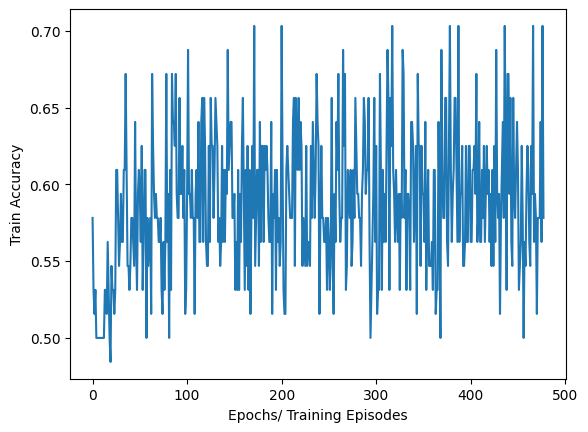

In [97]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy)
plt.xlabel('Epochs/ Training Episodes')
plt.ylabel('Train Accuracy')
## next attempt: try putting the new token into target since it should be the future action thats being compared


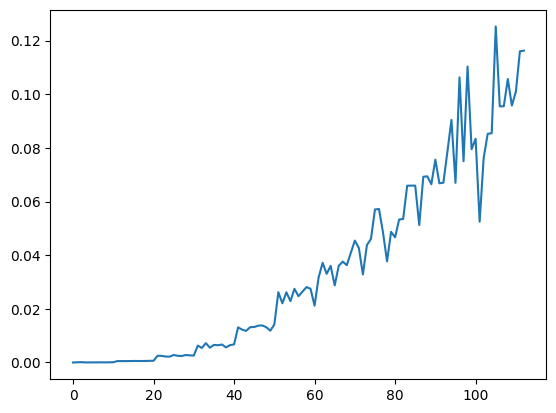

In [18]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.loss_))], ql.loss_)

## next attempt: try putting the new token into target since it should be the future action thats being compared

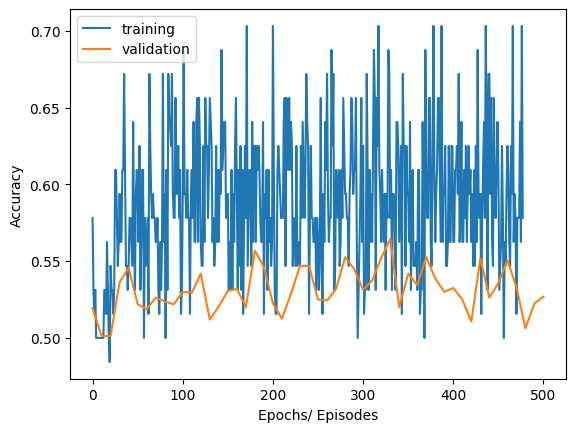

In [98]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy, label = 'training')
plt.plot([i*10 for i in range(len(ql.val_acc))], ql.val_acc, label = 'validation')
plt.xlabel('Epochs/ Episodes')
plt.ylabel('Accuracy')
plt.legend()
## next attempt: try putting the new token into target since it should be the future action thats being compared

In [110]:
test_x = list(pd.read_csv('sst2_test')['sentence'])
test_y = list(pd.read_csv('sst2_test')['label'])

with torch.no_grad():
    prompts, _ = ql.get_actions_Q_input_specific_target(val_x)
    accuracy = ql.get_accuracy(test_x, test_y, ' '.join(prompts[0]))

In [111]:
print(accuracy)

0.64
